# Step 0 - Configuration and setup of dependencies

In [7]:
# Dependencies installation
!pip install matplotlib
!pip install pandas
!pip install torch torchvision torchaudio


In [214]:
import cv2
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [215]:
# Hyper parameters
S = 7
B = 2
C = 3

# Step 1 - review dataset

In [216]:
import pandas as pd

# Specify the path to your Parquet file
image_dir = "../datasets/easy-500"
parquet_file_path = f"{image_dir}/images.parquet"
labels_parquet_file_path = f"{image_dir}/labels.parquet"

# Load the Parquet file into a DataFrame
img_labels = pd.read_parquet(parquet_file_path, engine='pyarrow')  # or engine='fastparquet'

df_labels = pd.read_parquet(labels_parquet_file_path)

print(df_labels)

def dump_images(df):
  for i, row in df.iterrows():
    image = cv2.imdecode(np.frombuffer(row['image'], np.uint8), cv2.IMREAD_COLOR)
    success = cv2.imwrite(f'../{image_dir}/{i}.jpg', image)

# Now you can work with the DataFrame `df`
print(img_labels.head())

dump_images(img_labels)

full_df = pd.read_parquet(labels_parquet_file_path)

# Split the DataFrame into training and validation sets
# Adjust 'split_ratio' as needed, e.g., 0.8 for 80% training and 20% validation
split_ratio = 0.8
split_index = int(len(full_df) * split_ratio)

train_df = full_df.iloc[:split_index]
val_df = full_df.iloc[split_index:]

       image_id    x    y  orientation  radius  class
0             0  269  450     0.000000      17      0
1             0  533  299     0.663225      45      1
2             0  539  427     0.610865      46      1
3             0  365  148     0.488692      45      1
4             0  472  136     2.426008      40      1
...         ...  ...  ...          ...     ...    ...
11495       499  356  363     0.575959      37      2
11496       499  477  371     2.268928      41      2
11497       499  934   74     2.076942      45      2
11498       499  525  283     0.506145      46      2
11499       499  284  397     5.916666      38      2

[11500 rows x 6 columns]
   id                                              image
0   0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1   1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2   2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3   3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4   4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00

cell x: 0, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 1, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 2, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 3, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 4, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 5, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 6, cell y: 0, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 0, cell y: 1, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 1, cell y: 1, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 2, cell y: 1, Object: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
cell x: 3, cell y: 1, Object: tensor([ 1.0000,  0.4609,  0.2656, 40.0000,  2.4260,  0.0000

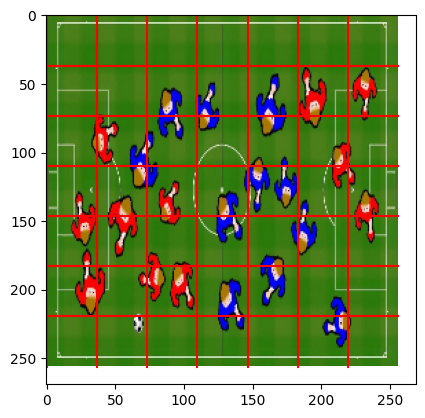

In [217]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class YOLODataset(Dataset):
    def __init__(self, df, img_dir, S=7, B=2, C=3, target_size=(256, 256)):
        # Load the annotations
        self.df = df  # Use the passed DataFrame
        self.S = S
        self.B = B
        self.C = C
        self.img_dir = img_dir
        self.target_size = target_size
        self.property_count = 5

    def __len__(self):
        # Number of unique images
        return self.df['image_id'].nunique()

    def __getitem__(self, idx):

        # Assuming 'image_id' is sorted or indexed to match idx
        image_id = self.df.iloc[idx]['image_id']

        # Filter entries for the current image
        label_data = self.df[self.df['image_id'] == image_id]

        img_path = f"{self.img_dir}/{int(self.df.iloc[idx]['image_id'])}.jpg"

        # Load image with cv2 and convert to RGB
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate the aspect ratio, note that the y and x is swapped in order        
        aspect_ratio = image.shape[1]/ self.target_size[1], image.shape[0] / self.target_size[0]

        # Resize image
        image = cv2.resize(image, self.target_size, interpolation=cv2.INTER_LINEAR)

        image_debug = image

        # Normalize image
        image = image / 255.0
        image = np.transpose(image, (2, 0, 1))  # From HWC to CHW
        image = torch.tensor(image, dtype=torch.float)

        # Initialize the target tensor with YOLOv1 structure [S][S][5xB + C]
        target = torch.zeros((self.S, self.S, 5*self.B + self.C))
        
        # Loop through objects (this part may need to be adjusted based on your data structure)
        for _, row in label_data.iterrows():
            # Normalize x, y, and radius
            x, y, radius = row['x'] / (self.target_size[0] * aspect_ratio[0]), row['y'] / (self.target_size[1] * aspect_ratio[1]), row['radius']
            #print(f"X: {x} y: {y}, radius: {radius}")
            
            # Determine the grid cell. Note: floor operation converts to int
            grid_x, grid_y = int(self.S * x), int(self.S * y)

            #print(f"grid_x: {grid_x} grid_y: {grid_y}")
            
            # Assuming 'class' is already an integer that can be one-hot encoded
            class_one_hot = torch.zeros((self.C,))
            class_one_hot[int(row['class'])] = 1
            
            # Populate the target tensor
            # Note: This example assumes B=1 for simplicity. You'll need to adjust it to handle multiple bounding boxes.
            obj_data = torch.tensor([1, x, y, radius, row['orientation'], *class_one_hot])
   
            # Debugging data data for this object
            # obj_data = [1, x*self.S - grid_x, y*self.S - grid_y, radius, row['orientation'], *class_one_hot]
            
            # Find an empty box slot
            box_found = False
            for b in range(self.B):
                if target[grid_x, grid_y, b*5] == 0:  # If the confidence score (first of the 5*B properties) is 0, the slot is empty
                    test_tensor = torch.tensor([1, x, y, radius, row['orientation']], dtype=torch.float32)
                    target[grid_x, grid_y, b*5:b*5+5] = torch.tensor([1, x, y, radius, row['orientation']], dtype=torch.float32)
                    target[grid_x, grid_y, 5*self.B:] = class_one_hot  # Class probabilities are the same for all boxes in the cell
                    box_found = True
                    break
            
            if not box_found:
                # If no break occurred, all bounding boxes for this cell are filled
                assert False, f"More objects in cell ({grid_x}, {grid_y}) than allowed by B={self.B}"   
            
        return image, image_debug, target

# Example usage
S = 7
image_size = (256,256)
dataset = YOLODataset(train_df, img_dir=image_dir, S=S, B=2, C=3)
image, image_debug, target = dataset.__getitem__(0)

for y in range(S):
    for x in range(S):
        print(f"cell x: {x}, cell y: {y}, Object: {target[x][y]}")

print(target.shape)

print(image.shape)

plt.imshow(image_debug);

for i in range(7):
    plt.plot([i* (image_size[0]/S), i * (image_size[0]/S)], [0, image_size[0]], color='red')
    plt.plot([0, image_size[1]], [i* (image_size[1]/S), i * (image_size[1]/S)], color='red')    

Next lets make a function that can print out a given input image and prediction.

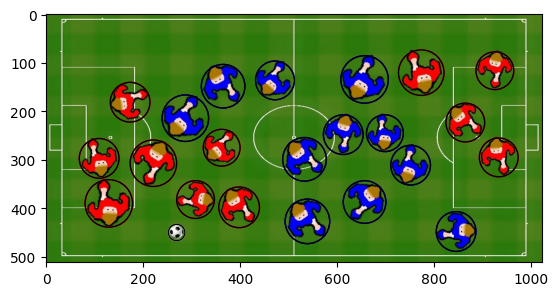

In [237]:
def choose_color(value):
    colors = ['white', 'blue', 'red']
    if 0 <= value < len(colors):
        return colors[value]
    else:
        # Handle the error: return a default color or raise an exception
        return 'black'  # Default color if value is out of range

def plot_prediction_diagram(input_image, label_data, prediction):
    plt.imshow(input_image);

    # Render ground truth
    for _, row in label_data.iterrows():
        x, y, radius = row['x'], row['y'], row['radius']

        color = choose_color(int(row['class']))

        circle = Circle((x, y), radius, color=color, fill=False)

        # Get the current axes, adding the circle to the plot
        ax = plt.gca()
        ax.add_patch(circle)

        # Optionally, set the aspect of the plot to 'equal' to ensure the circle isn't elliptical
        ax.set_aspect('equal')

    bbox_properties = prediction[..., :B*5]
    flattened_properties = bbox_properties.reshape(-1, 5)
    for i in range(flattened_properties.shape[0]):
        # Extract the circle properties
        _, x, y, radius, _ = flattened_properties[i]

        x = x * input_image.shape[1]
        y = y * input_image.shape[0]

        circle = Circle((x, y), radius, color='black', fill=False)

        # Get the current axes, adding the circle to the plot
        ax = plt.gca()
        ax.add_patch(circle)

        # Optionally, set the aspect of the plot to 'equal' to ensure the circle isn't elliptical
        ax.set_aspect('equal')

    

idx = 0

# Assuming 'image_id' is sorted or indexed to match idx
test_image_id = train_df.iloc[idx]['image_id']

# Filter entries for the current image
test_label_data = train_df[train_df['image_id'] == test_image_id]

test_img_path = f"{image_dir}/{int(train_df.iloc[idx]['image_id'])}.jpg"

# Load image with cv2 and convert to RGB
test_image = cv2.imread(test_img_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

test_dataset = YOLODataset(train_df, img_dir=image_dir, S=S, B=2, C=3)
_, _, target = dataset.__getitem__(0)

plot_prediction_diagram(test_image, test_label_data, target)

# Step 2 - Setup the Model

For testing, lets create our simple yolo model

In [221]:
import torch
import torch.nn as nn

class SimpleYOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3, image_size=(256, 256), color_depth=3, feature_map_size=16, stride=2, linear_size=512):
        super(SimpleYOLO, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        # Adjusted for input images and using stride for max pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=color_depth, out_channels=feature_map_size, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=stride)  # Using stride explicitly for clarity
        )

        # Calculate the size of the feature map after pooling
        conv_output_dim = self.calculate_output_dim(input_dim=256, kernel_size=3, stride=2, padding=1)
        
        pool_output_dim = self.calculate_output_dim(input_dim=conv_output_dim, kernel_size=2, stride=2, padding=0)

        conv_output_height = pool_output_dim
        conv_output_width = pool_output_dim

        # Calculate the size of the feature map after pooling
        conv_output_size = conv_output_width * conv_output_height

        # Flatten the output for the linear layers
        self.flatten_size = feature_map_size * conv_output_size
        self.fc1 = nn.Linear(self.flatten_size, linear_size)
        self.fc2 = nn.Linear(linear_size, self.S * self.S * (5 * self.B + self.C))  # Explicit output size

    @staticmethod
    def calculate_output_dim(input_dim, kernel_size, stride, padding):
        return (input_dim - kernel_size + 2 * padding) // stride + 1

    def forward(self, x):
        x = self.layer1(x)
        x = x.view(-1, self.flatten_size)  # Flatten the output for the linear layer
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.S, self.S, 5*self.B + self.C)
        return x


Next we define our loss function

In [223]:
import torch
import torch.nn as nn

class CustomYOLOLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3, lambda_coord=5, lambda_noobj=0.5, lambda_orientation=0.5):
        super(CustomYOLOLoss, self).__init__()
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.lambda_orientation = lambda_orientation

    def forward(self, predictions, targets):
        #print(f"Predictions.shape: {predictions.shape}")
        #print(f"targets.shape: {targets.shape}")
        batch_size = predictions.shape[0]
        #print(f"batch_size: {batch_size}")

        # Separate bounding box parameters and class probabilities
        # Assuming the last C elements are class probabilities for each cell in the grid
        bbox_params = self.B * 5
        pred_bbox = predictions[..., :bbox_params].view(batch_size, self.S, self.S, self.B, 5)
        #print(f"pred_bbox: {pred_bbox.shape}")
        pred_classes = predictions[..., bbox_params:].view(batch_size, self.S, self.S, self.C)
        #print(f"pred_bbox: {pred_classes.shape}")
        
        target_bbox = targets[..., :bbox_params].view(batch_size, self.S, self.S, self.B, 5)
        #print(f"target_bbox: {target_bbox.shape}")
        target_classes = targets[..., bbox_params:].view(batch_size, self.S, self.S, self.C)
        #print(f"target_classes: {target_classes.shape}")

        # Masks for objects and no-objects based on confidence score in targets
        obj_mask = target_bbox[..., 0] > 0.5  # Assuming confidence score > 0.5 indicates object presence
        #print(f"obj_mask: {obj_mask.shape}")
        no_obj_mask = target_bbox[..., 0] <= 0.5
        #print(f"no_obj_mask: {no_obj_mask.shape}")
        obj_mask_indices = obj_mask.nonzero(as_tuple=True)
        no_obj_mask_indices = no_obj_mask.nonzero(as_tuple=True) 

        # Coordinate Loss
        coord_loss = self.lambda_coord * torch.sum((pred_bbox[obj_mask_indices][..., 1:3] - target_bbox[obj_mask_indices][..., 1:3]) ** 2)

        # Radius Loss
        radius_loss = self.lambda_coord * torch.sum((torch.sqrt(targets[obj_mask_indices][..., 3:4]) -  torch.sign(predictions[obj_mask_indices][..., 3:4]) * torch.sqrt(torch.abs(predictions[obj_mask_indices][..., 3:4]))) ** 2)

        # Confidence Loss for objects and no-objects
        conf_loss_obj = torch.sum((predictions[obj_mask_indices][..., 0:1] - targets[obj_mask_indices][..., 0:1]) ** 2)
        conf_loss_no_obj = self.lambda_noobj * torch.sum(predictions[no_obj_mask_indices][..., 0:1] ** 2)

        # Orientation Loss
        orient_loss = self.lambda_orientation * torch.sum((predictions[obj_mask_indices][..., 4:5] - targets[obj_mask_indices][..., 4:5]) ** 2)

        # Class Probability Loss (calculated across all cells, not just where an object is present)
        # class_loss = torch.sum((pred_classes - target_classes) ** 2)
        class_loss = torch.sum((predictions[obj_mask_indices][..., 5:] - targets[obj_mask_indices][..., 5:]) ** 2)

        # Total Loss
        total_loss = (coord_loss + radius_loss + conf_loss_obj + conf_loss_no_obj + orient_loss + class_loss) / batch_size

        #print(f"total_loss: {total_loss}, coord_loss{coord_loss}, radius_loss{radius_loss}, conf_loss_obj: {conf_loss_obj}, conf_loss_no_obj: {conf_loss_no_obj}, orient_loss: {orient_loss}, class_loss: {class_loss}")

        return total_loss

Now lets perform our training

In [224]:
# Assuming you have YOLODataset for training and validation
train_dataset = YOLODataset(train_df, image_dir, S=S, B=B, C=C)
val_dataset = YOLODataset(val_df, image_dir, S=S, B=B, C=C)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

# Initialize the model, loss function, and optimizer
model = SimpleYOLO(S=S, B=B, C=C)
loss_function = CustomYOLOLoss(S=S, B=B, C=C, lambda_coord=5, lambda_noobj=0.5, lambda_orientation=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 150  # Set the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for images, image_debug, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = loss_function(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        
        total_train_loss += loss.item()

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for images, image_debug, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1/150, Training Loss: 6451.9753, Validation Loss: 92.4944
Epoch 2/150, Training Loss: 92.7066, Validation Loss: 91.9847
Epoch 3/150, Training Loss: 95.1538, Validation Loss: 91.1578
Epoch 4/150, Training Loss: 91.0092, Validation Loss: 90.1677


KeyboardInterrupt: 